## Finding the Best Classification Model for Intel Image Dataset

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd

from sklearn.utils import shuffle
from sklearn.neighbors import NearestCentroid, KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

import seaborn as sns

from keras.datasets import fashion_mnist
from keras.utils.np_utils import to_categorical   

import cv2
import csv
import os

import warnings
warnings.filterwarnings('ignore')

seed = 1234
np.random.seed(seed) 

2022-12-21 22:06:40.061992: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Import Data Images

In [2]:
## Image clean source: https://www.kaggle.com/code/uzairrj/beg-tut-intel-image-classification-93-76-accur

def get_images(path):
    IntelData, Labels = [], []
    
    for labels in os.listdir(path):
        for image_file in os.listdir(path+labels):
            image = cv2.imread(path+labels+r'/'+image_file)
            image = cv2.resize(image,(150,150))
            IntelData.append(image)
            Labels.append(Word_to_Label([labels][0]))
    return shuffle(IntelData,Labels,random_state=seed)
    
def Label_to_Word(label):
    label_dict = {0:"buildings", 1:"forest", 2:"glacier", 3:"mountain", 4:"sea", 5:"street"}
    return label_dict[label]

def Word_to_Label(word):
    word_dict = {"buildings": 0, "forest":1, "glacier":2, "mountain":3, "sea":4, "street":5}
    return word_dict[word]

In [3]:
## read training images

X_tr, y_tr = get_images('../IntelData/Data/seg_train/seg_train/')
X_tr = np.array(X_tr)
y_tr = np.array(y_tr)

X_te, y_te = get_images('../IntelData/Data/seg_test/seg_test/')
X_te = np.array(X_te)
y_te = np.array(y_te)

X_tr = X_tr.astype(int)
X_te = X_te.astype(int)

y_tr = y_tr.astype(int)
y_te = y_te.astype(int)

print(X_tr.shape, y_tr.shape)
print(X_te.shape, y_te.shape)


(14034, 150, 150, 3) (14034,)
(3000, 150, 150, 3) (3000,)


### Take a Glimpse at the Data

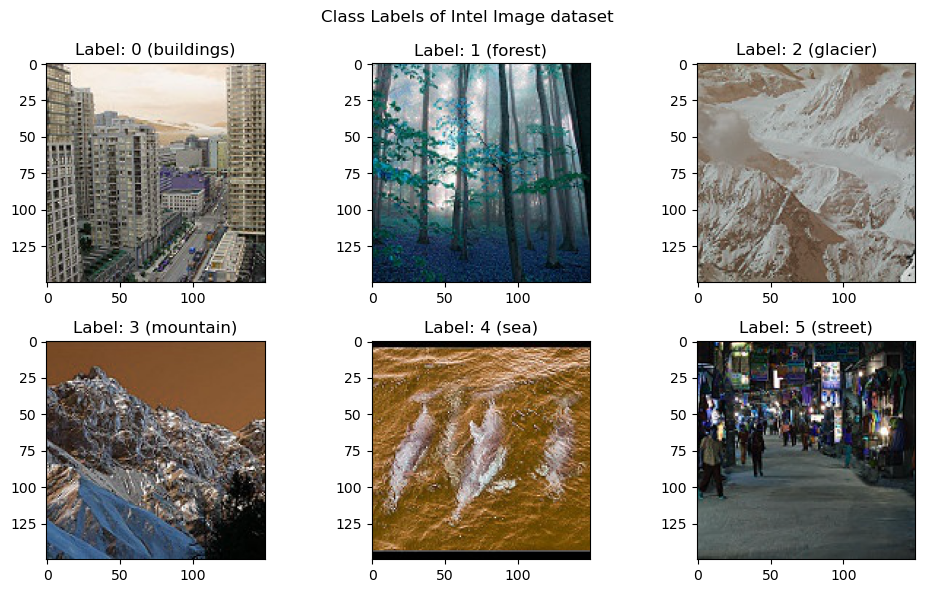

In [4]:
def find(arr, elem):
    for index, item in enumerate(arr):
        if item == elem:
            return index

figure, axes = plt.subplots(2, 3, figsize=(10, 6)) 

TrueLabels = {0:"buildings", 1:"forest", 2:"glacier", 3:"mountain", 4:"sea", 5:"street"}

i = 0
for x in range(2): 
    for y in range(3):
        index = find(y_tr, i)
        axes[x, y].imshow(X_tr[index]) 
        axes[x, y].set_title(f'Label: {i} ({TrueLabels[i]})') 
        i+= 1

plt.suptitle("Class Labels of Intel Image dataset")
plt.tight_layout() 


### Clean and Standardize Data

In [5]:
X_tr = np.reshape(X_tr, (14034,67500))
X_te = np.reshape(X_te, (3000,67500))

y_tr = y_tr.flatten()
y_te = y_te.flatten()

X_te_pre = X_te.copy()

scaler = StandardScaler()
scaler.fit(X_tr)
X_tr = scaler.transform(X_tr)
X_te = scaler.transform(X_te)

X_tr, X_val, y_tr, y_val = train_test_split(X_tr, y_tr, test_size=0.20, random_state=seed, shuffle=True)

print(X_tr.shape, y_tr.shape)
print(X_val.shape, y_val.shape)

(11227, 67500) (11227,)
(2807, 67500) (2807,)


### Line Graph to Compare Results

In [6]:
def line_graph(x, y_train, y_val, title, x_label, y_label, color='blue', loc='upper right'):
    fig, axes = plt.subplots()

    axes.semilogx(x, y_train, linestyle='-', marker='x', color=color, label='Train')
    axes.semilogx(x, y_val, linestyle='--', marker='x', color=color, label='Validation')

    axes.legend(loc=loc)
    axes.set_xlabel(x_label, fontsize=14)
    axes.set_ylabel(y_label, fontsize=14)
    axes.set_title(title)
    return plt

### Make Confusion Matrix

In [7]:
def cm(y_pred, title):
    fig, ax = plt.subplots(figsize=(7, 5))

    sklearn_cm_eu = confusion_matrix(y_te, y_pred)
    sns.heatmap(sklearn_cm_eu, annot=True, ax=ax, fmt='g')

    ax.set_ylabel("True Label")
    ax.set_xlabel("Predicted Label")

    ax.set_title(f"Confusion Matrix of Fashion-MNIST using {title}")
    return plt

### Record Results

In [8]:
def write_results(file, settings, headers):   
    with open(file, "a", newline='\n') as f:
        writer = csv.DictWriter(f, fieldnames=headers)
        writer.writerow(settings)

def view_results(file):
    df = pd.read_csv(file)
    return df

### Show Incorrect Predictions

In [9]:
def find_incorrect(predictions, true_label, predict_label):
    
    results = []
    length = len(y_te)
    for i in range(length):
        if y_te[i] == true_label and predictions[i] == predict_label:
            results.append(i)
        if len(results) == 10:
            return results

def print_incorrect(predictions, true_label, predict_label):
    
    indices = find_incorrect(predictions, true_label, predict_label)
    
    plt.rcParams['image.interpolation'] = 'nearest'
    plt.rcParams['image.cmap'] = 'gray' 
    fig, axes = plt.subplots(2, 5, figsize=(10, 5))
    
    for i in range(10):
        axes[i//5, i%5].imshow(X_te_pre[indices[i]].reshape(150, 150, 3).astype('uint8'))
        
    fig.suptitle(f"Images of {TrueLabels[true_label]} And Predicted As {TrueLabels[predict_label]}")
    plt.tight_layout()
    return plt

### Nearest Centroid

In [10]:
nc = NearestCentroid().fit(X_tr, y_tr)
train_predict = nc.predict(X_tr)
val_predict = nc.predict(X_val)
test_predict = nc.predict(X_te)

results = {"Train Accuracy": [0], "Validation Accuracy": [0], "Test Accuracy": [0]}

results["Train Accuracy"][0] = accuracy_score(y_tr, train_predict)
results["Validation Accuracy"][0] = accuracy_score(y_val, val_predict)
results["Test Accuracy"][0] = accuracy_score(y_te, test_predict)

df_nc = pd.DataFrame(results)

df_nc

,Train Accuracy,Validation Accuracy,Test Accuracy
0,0.443217,0.444959,0.439667


In [11]:
df_nc.to_csv('./results/nc.csv', index=False)

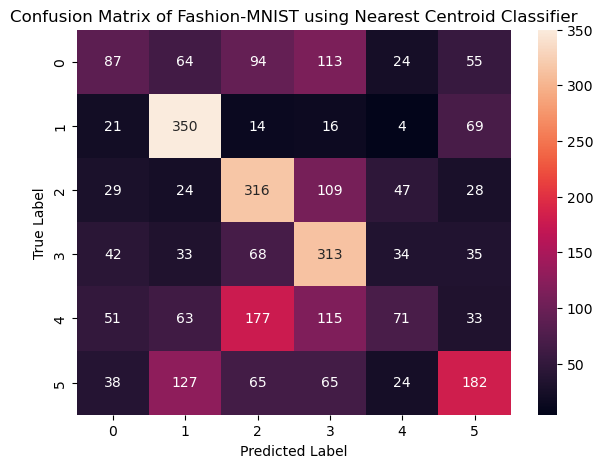

In [12]:
cm_knn = cm(test_predict, "Nearest Centroid Classifier")
cm_knn.show()

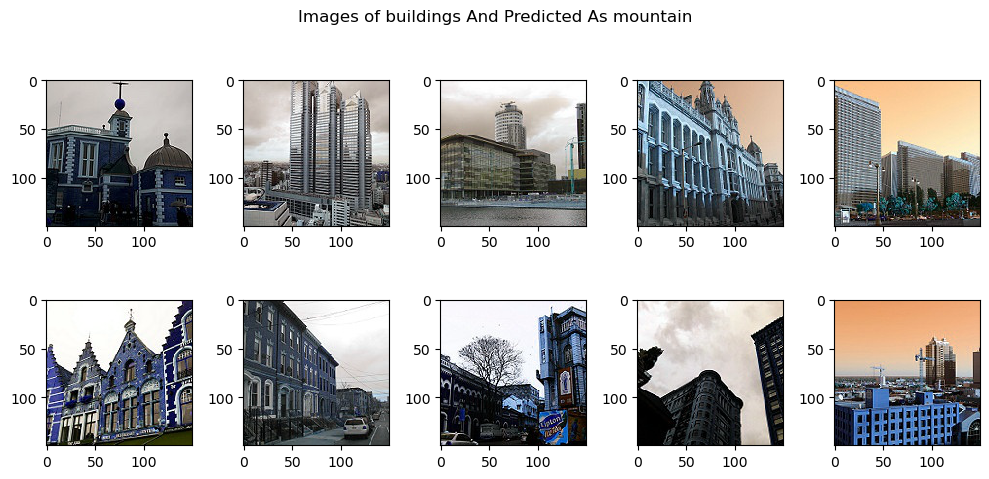

In [13]:
wrong_predictions = print_incorrect(test_predict, 0, 3)
wrong_predictions.show()

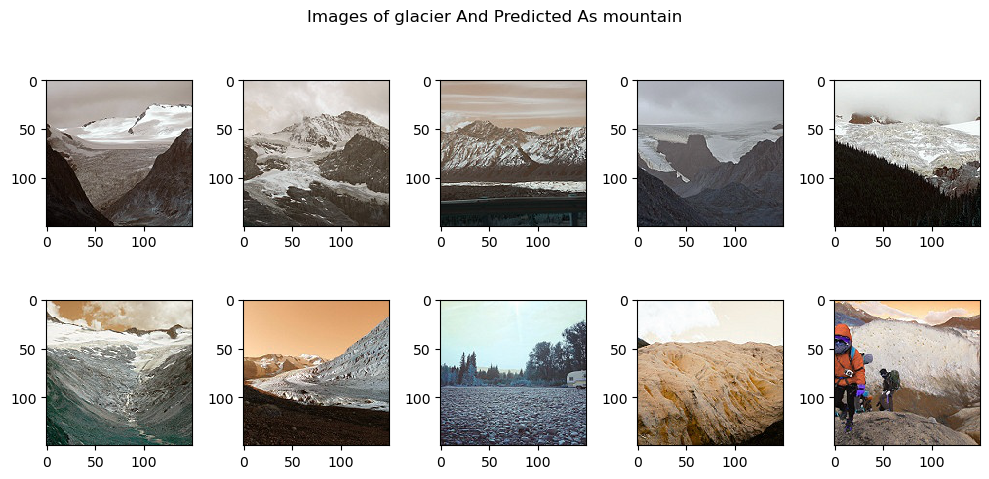

In [14]:
wrong_predictions = print_incorrect(test_predict, 2, 3)
wrong_predictions.show()

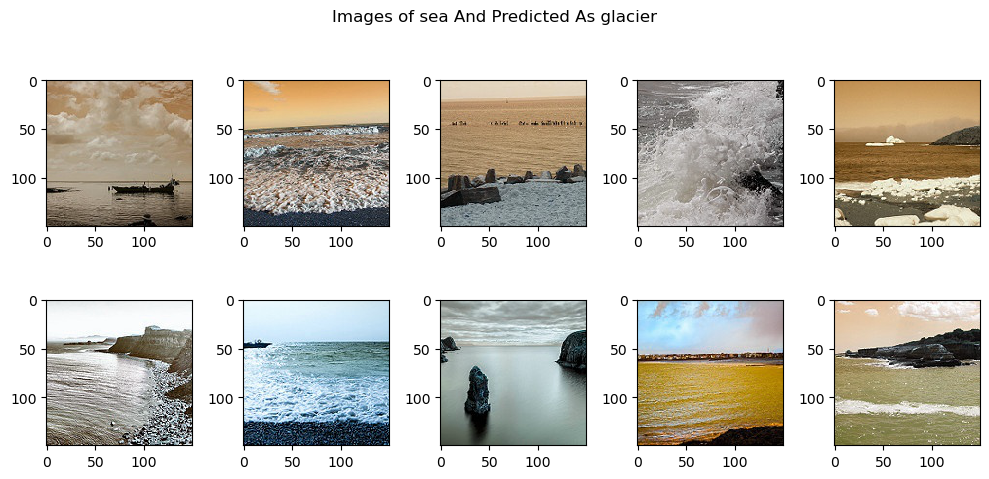

In [15]:
wrong_predictions = print_incorrect(test_predict, 4, 2)
wrong_predictions.show()

### KNN Classifier

In [16]:
def knnTrain(distance):

    HEADERS = ["K value", "Train Accuracy", "Validation Accuracy"]
    k_vals = [2, 5, 10, 15, 20, 30, 50]
    
    accuracies_train = np.zeros(len(k_vals))
    accuracies_val = np.zeros(len(k_vals))
    accuracies_test = np.zeros(len(k_vals))
    y_predictions = []
    
    for i, k in enumerate(k_vals):
        knn = KNeighborsClassifier(n_neighbors=k, metric=distance)
        knn.fit(X_tr, y_tr)
        y_pred_train, y_pred_val, y_pred_test = knn.predict(X_tr), knn.predict(X_val), knn.predict(X_te)
        accuracies_train[i] = accuracy_score(y_tr, y_pred_train)
        accuracies_val[i] = accuracy_score(y_val, y_pred_val)
        accuracies_test[i] = accuracy_score(y_te, y_pred_test)
        y_predictions.append(y_pred_test)
        print(distance, k, accuracies_train[i], accuracies_val[i],accuracies_test[i])
    
    return accuracies_train, accuracies_val, accuracies_test, y_predictions

In [17]:
## predicting using 
k_vals = [2, 5, 10, 15, 20, 30, 50]
acc_train_eu, acc_val_eu, acc_test_eu, y_pred_eu = knnTrain('euclidean')

df_eu = pd.DataFrame({"K Value": k_vals, "Train Accuracy": acc_train_eu, 
                   "Validation Accuracy": acc_val_eu})
df_eu.style.set_caption("KNN Accuracy Using Euclidean Distance")

euclidean 2 0.7435646210029393 0.3452084075525472 0.3456666666666667
euclidean 5 0.45657789258038656 0.3694335589597435 0.35933333333333334
euclidean 10 0.40803420325999823 0.37228357677235485 0.37433333333333335
euclidean 15 0.40179923398948963 0.37727110794442464 0.37766666666666665
euclidean 20 0.39832546539592056 0.38368364802280014 0.38266666666666665
euclidean 30 0.40001781419791577 0.38902743142144636 0.3873333333333333
euclidean 50 0.4025118019061192 0.3979337370858568 0.392


,K Value,Train Accuracy,Validation Accuracy
0,2,0.743565,0.345208
1,5,0.456578,0.369434
2,10,0.408034,0.372284
3,15,0.401799,0.377271
4,20,0.398325,0.383684
5,30,0.400018,0.389027
6,50,0.402512,0.397934


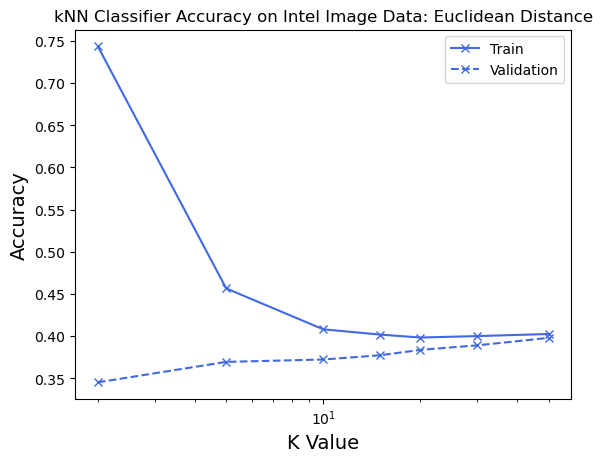

In [18]:
graph = line_graph(k_vals, acc_train_eu, acc_val_eu, 'kNN Classifier Accuracy on Intel Image Data: Euclidean Distance',
                  'K Value', 'Accuracy', 'royalblue')

graph.show()

In [19]:
df_eu["Test Accuracy"] = acc_test_eu
df_eu

,K Value,Train Accuracy,Validation Accuracy,Test Accuracy
0,2,0.743565,0.345208,0.345667
1,5,0.456578,0.369434,0.359333
2,10,0.408034,0.372284,0.374333
3,15,0.401799,0.377271,0.377667
4,20,0.398325,0.383684,0.382667
5,30,0.400018,0.389027,0.387333
6,50,0.402512,0.397934,0.392000


In [20]:
df_eu.to_csv('./results/knn_eu.csv', index=False)

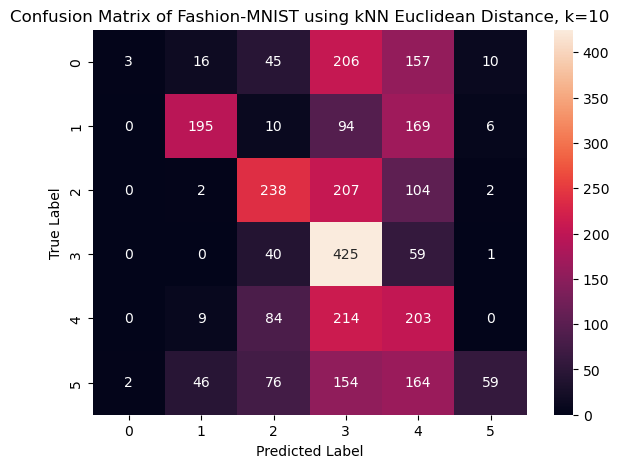

In [21]:
cm_knn = cm(y_pred_eu[2], "kNN Euclidean Distance, k=10")
cm_knn.show()

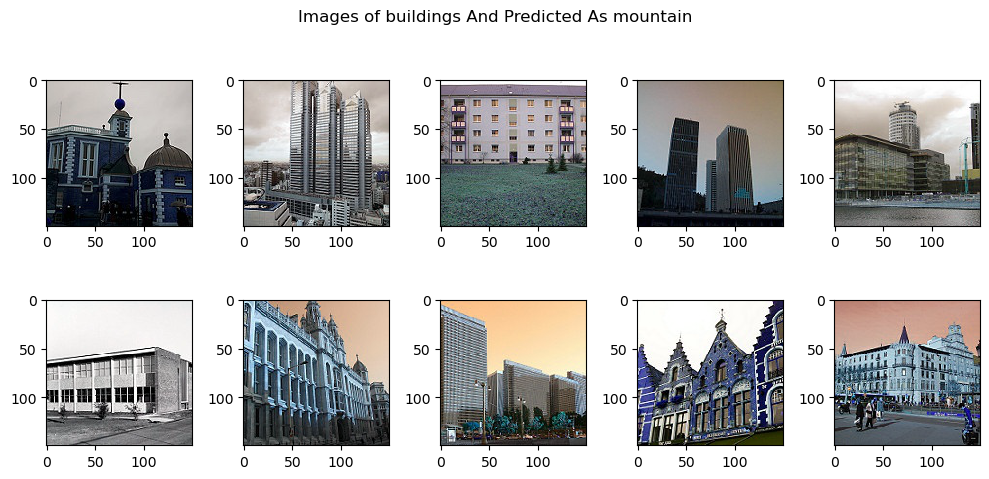

In [24]:
wrong_predictions = print_incorrect(y_pred_eu[2], 0, 3)
wrong_predictions.show()

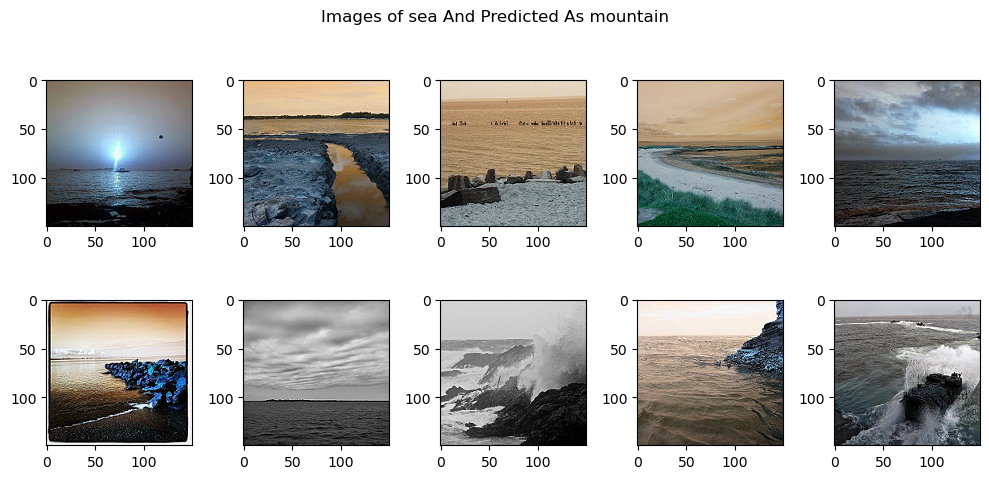

In [25]:
wrong_predictions = print_incorrect(y_pred_eu[2], 4, 3)
wrong_predictions.show()

### Neural Network

In [26]:
DEFAULTS_NN = {"Hidden Layers": (100), "Activation": 'relu', "Solver": "adam", "Learning Rate": 0.001,
           "Batch Size": 'auto', "Regularization Strength": 0.0001, "Train Accuracy": 0, "Validation Accuracy": 0}
HEADERS_NN = ["Hidden Layers", "Activation", "Solver", "Learning Rate", "Batch Size",
           "Regularization Strength", "Train Accuracy", "Validation Accuracy"]

In [27]:
def neural_network(settings, hidden=(100), activation='relu', solver='adam', 
                   learning_rate=0.001, batch='auto', r_strength=0.0001):
    neural_network = MLPClassifier(hidden_layer_sizes=hidden, activation=activation, solver=solver,
                                  alpha=r_strength, batch_size=batch, learning_rate_init=learning_rate,
                                  random_state=seed).fit(X_tr, y_tr)
    
    predict_tr = neural_network.predict(X_tr)
    predict_val = neural_network.predict(X_val)
    
    accuracy_tr = accuracy_score(y_tr, predict_tr)
    accuracy_val = accuracy_score(y_val, predict_val)
    
    settings["Hidden Layers"] = hidden
    settings["Activation"] = activation
    settings["Solver"] = solver
    settings["Learning Rate"] = learning_rate
    settings["Batch Size"] = batch
    settings["Regularization Strength"] = r_strength
    settings["Train Accuracy"] = accuracy_tr
    settings["Validation Accuracy"] = accuracy_val
    
    print(settings)
    
    return settings

In [28]:
## test with default settings
file_nn = './results/neural_network.csv'

default_predict = neural_network(DEFAULTS_NN.copy())
write_results(file_nn, default_predict, HEADERS_NN)


{'Hidden Layers': 100, 'Activation': 'relu', 'Solver': 'adam', 'Learning Rate': 0.001, 'Batch Size': 'auto', 'Regularization Strength': 0.0001, 'Train Accuracy': 0.9794246014073217, 'Validation Accuracy': 0.5757035981474884}


In [ ]:
## Test for best solver

lbfgs = neural_network(DEFAULTS_NN.copy(), solver='lbfgs')
write_results(file_nn, lbfgs, HEADERS_NN)

sgd = neural_network(DEFAULTS_NN.copy(), solver='sgd')
write_results(file_nn, sgd, HEADERS_NN)

{'Hidden Layers': 100, 'Activation': 'relu', 'Solver': 'lbfgs', 'Learning Rate': 0.001, 'Batch Size': 'auto', 'Regularization Strength': 0.0001, 'Train Accuracy': 0.999109290104213, 'Validation Accuracy': 0.5764161026006412}
